In [8]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
from keras.callbacks import EarlyStopping
import keras
from matplotlib import style
style.use("seaborn-v0_8-dark")

In [9]:
base_dir = "/kaggle/input/predict-energy-behavior-of-prosumers"

In [10]:
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), parse_dates=True)

In [11]:
# for i in range(0, 15):
#     county = train[train['county']==i]
#     print(f'county{i}: {county.shape[0]}')
# train = train[train['county']==0]
train = train[train['is_consumption']==1]


In [12]:
train = train.groupby(['datetime'])['target'].mean().reset_index()
train.head()

,datetime,target
0,2021-09-01 00:00:00,325.570623
1,2021-09-01 01:00:00,315.820951
2,2021-09-01 02:00:00,315.752328
3,2021-09-01 03:00:00,311.909574
4,2021-09-01 04:00:00,317.493836


In [13]:
dataset = train
dataset["Month"] = pd.to_datetime(dataset["datetime"]).dt.month
dataset["Year"] = pd.to_datetime(dataset["datetime"]).dt.year
dataset["Date"] = pd.to_datetime(dataset["datetime"]).dt.date
dataset["Time"] = pd.to_datetime(dataset["datetime"]).dt.time
dataset["Week"] = pd.to_datetime(dataset["datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(dataset["datetime"]).dt.day_name()
dataset = dataset.set_index("datetime")
dataset.index = pd.to_datetime(dataset.index)

In [14]:
dataset = dataset[121:-72]

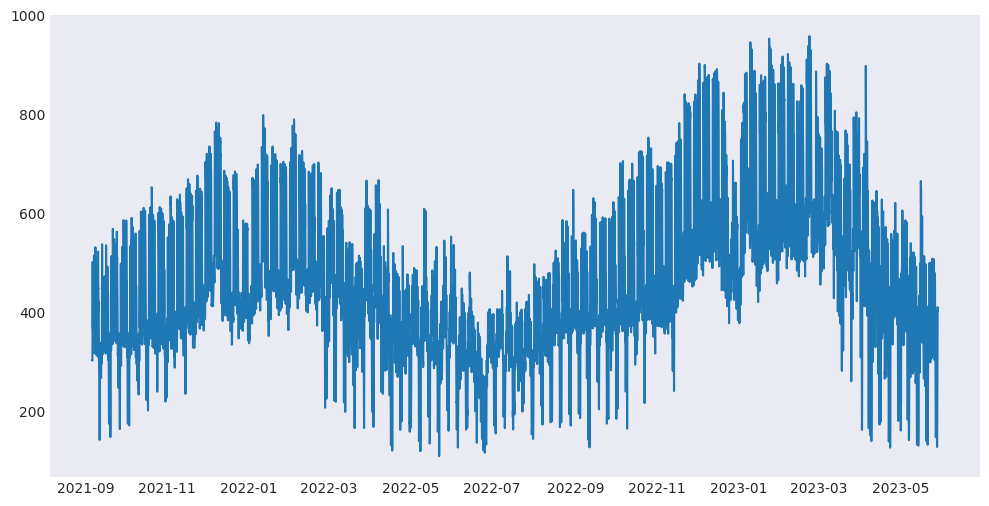

In [15]:
plt.figure(figsize=(12,6))
plt.plot(dataset["target"])

/tmp/ipykernel_42/1755328152.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["target"])


Text(0.5, 1.0, 'Energy Distribution')

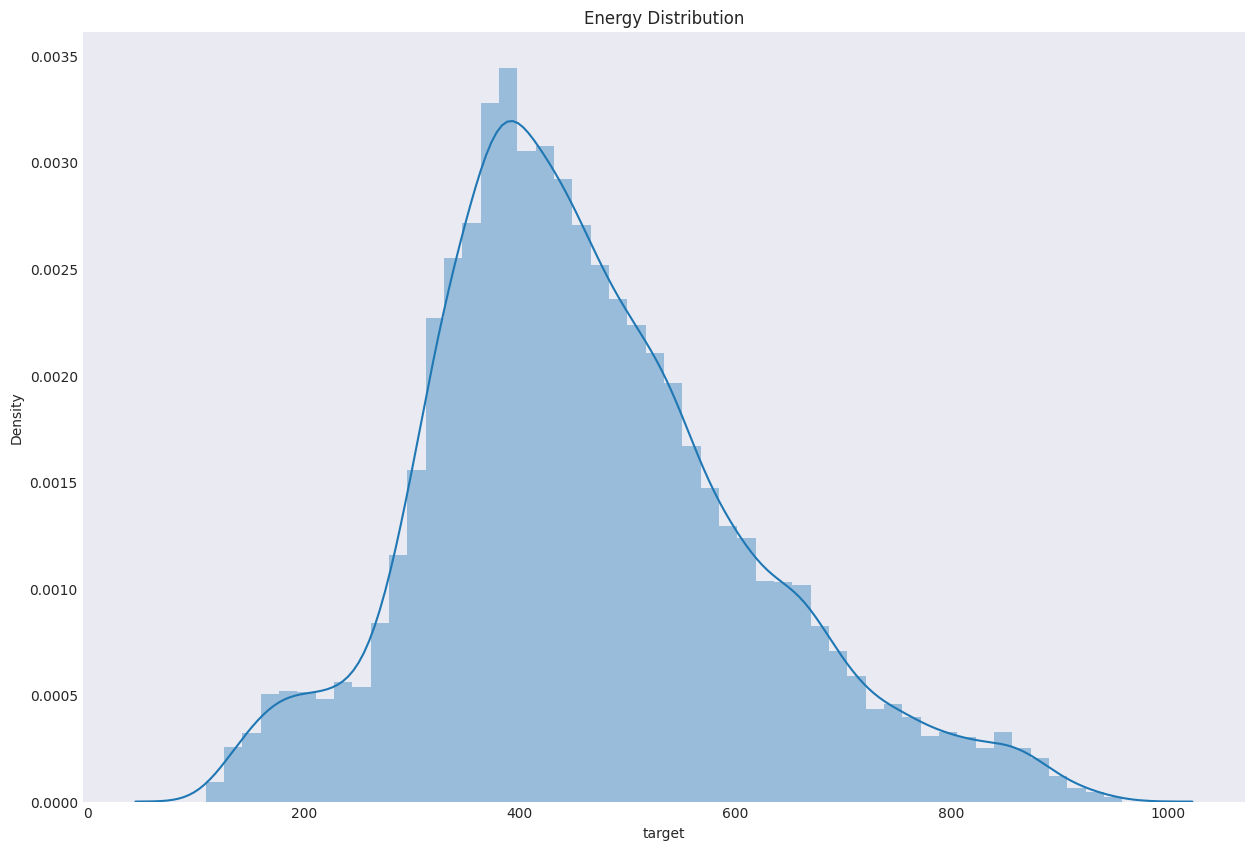

In [16]:
fig = plt.figure(figsize = (15,10))
sns.distplot(dataset["target"])
plt.title("Energy Distribution")

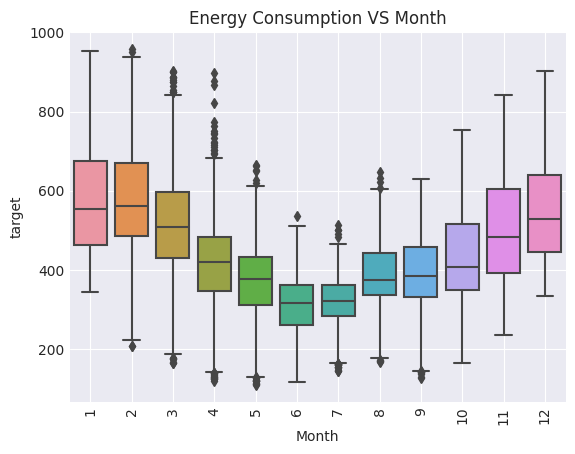

In [17]:
  
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

sns.boxplot(x=dataset["Month"], y=dataset["target"], data= dataset)
plt.title("Energy Consumption VS Month")
plt.xlabel("Month")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

plt.show()

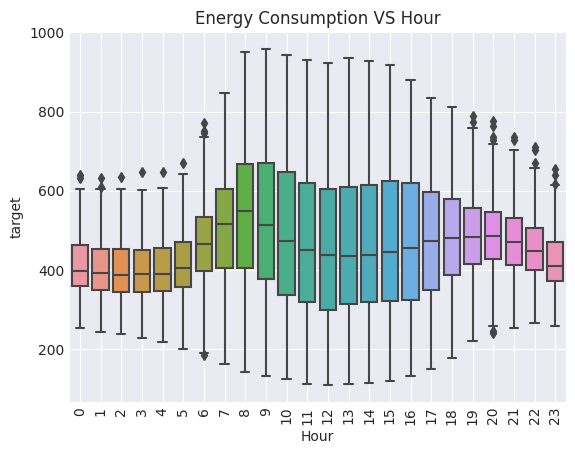

In [18]:
dataset1 = dataset
fig, ax1 = plt.subplots()
sns.boxplot(x=dataset1.index.hour, y=dataset1.target, data= dataset)
plt.title("Energy Consumption VS Hour")
plt.xlabel("Hour")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

In [19]:
dataset = dataset.drop(['Time', 'Day', 'Date'], axis=1)
newDataSet = dataset.resample("D").mean()

,target,Month,Year,Week
datetime,,,,
2021-09-06,389.732316,9.0,2021.0,36.0
2021-09-07,394.129101,9.0,2021.0,36.0
2021-09-08,424.580922,9.0,2021.0,36.0
2021-09-09,379.625703,9.0,2021.0,36.0
2021-09-10,404.478858,9.0,2021.0,36.0


In [ ]:
y = newDataSet["target"]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1)) 
y = scaler.fit_transform(np.array(y).reshape(-1,1))

In [ ]:
training_size = int(len(y)*0.80)
val_size = int(len(y)*0.90)
train_data = y[0:training_size,:]
val_data = y[training_size:val_size,:1]
test_data = y[val_size:,:1]


In [ ]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [] , []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 2
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)


In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 20)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_test)

In [ ]:
mae = mean_absolute_error(ytest, test_predict)
print('MAE Test Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(ytest, test_predict))
print('RMSE Test Data: '+str(rmse))

mae = mean_absolute_error(y_train, train_predict)
print('MAE Train Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print('RMSE Train Data: '+str(rmse))


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)
     

In [ ]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


In [ ]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

In [ ]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[129:, :] = actual.tolist()
plt.plot(ActualPlot)

TrainPredictionsPlot = np.empty_like(y )
TrainPredictionsPlot[:, :] = np.nan
TrainPredictionsPlot[129:, :] = train_predictions.tolist()
plt.plot(TrainPredictionsPlot)

plt.legend(['actual','train_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

In [ ]:
# Predicting consumption using validation data
val_predictions = model.predict(X_val)
val_predictions =scaler.inverse_transform(val_predictions)

yval = yval.reshape(yval.shape[0], 1)
actual_val = scaler.inverse_transform(yval)

val_results = pd.DataFrame()
val_results["Val Predictions"] = val_predictions.tolist()
val_results["Actuals_val"] = actual_val.tolist()

val_results

In [ ]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_val.tolist()
plt.plot(ActualPlot)

# Validation Prediction
ValPredictionsPlot = np.empty_like(y)
ValPredictionsPlot[:, :] = np.nan
ValPredictionsPlot[570:, :] = val_predictions.tolist()
plt.plot(ValPredictionsPlot)

plt.legend(['actual_val','Val_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [ ]:
# Predicting consumption using test data
test_predictions = model.predict(X_test)
test_predictions =scaler.inverse_transform(test_predictions)

ytest = ytest.reshape(ytest.shape[0], 1)
actual_test = scaler.inverse_transform(ytest)

test_results = pd.DataFrame()
test_results["test Predictions"] = test_predictions.tolist()
test_results["Actuals_test"] = actual_test.tolist()

test_results

In [ ]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_test.tolist()
plt.plot(ActualPlot)

# Test Prediction
TestPredictionsPlot = np.empty_like(y)
TestPredictionsPlot[:, :] = np.nan
TestPredictionsPlot[570:, :] = test_predictions.tolist()
plt.plot(TestPredictionsPlot)

plt.legend(['Actual_test','Test_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [ ]:
print(len(test_data))
print(test_data[0])
print(len(train_data))
x_input=test_data[337:].reshape(1,-1)
print(x_input.shape)
# print(x_input[0])
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
# print(temp_input)

In [ ]:
# # demonstrate prediction for next 30 days
# from numpy import array

# lst_output=[]
# n_steps=100
# i=0
# test = ""
# while(i<30):
    
#     if(len(temp_input)>100):
#         test = "if"
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         test="else"
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         #print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         #print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1

    
# print(test)
# print(len(lst_output))

In [ ]:
# print(len(y))
# day_new=np.arange(1,101)
# day_pred=np.arange(101, 131 )
# plt.figure(figsize = (15,10))
# plt.plot(day_new,scaler.inverse_transform(y[2084:]))
# plt.plot(day_pred,scaler.inverse_transform(lst_output))
# print(scaler.inverse_transform(lst_output))

In [ ]:
# df3=y.tolist()
# df3.extend(lst_output)
# plt.figure(figsize=(15,10))
# plt.plot(df3[2000:])


In [ ]:


model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1))))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50)))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
# model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 10)


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_test)

In [ ]:
mae = mean_absolute_error(ytest, test_predict)
print('MAE Test Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(ytest, test_predict))
print('RMSE Test Data: '+str(rmse))

mae = mean_absolute_error(y_train, train_predict)
print('MAE Train Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print('RMSE Train Data: '+str(rmse))

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [ ]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)

In [ ]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

In [ ]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[129:, :] = actual.tolist()
plt.plot(ActualPlot)

TrainPredictionsPlot = np.empty_like(y )
TrainPredictionsPlot[:, :] = np.nan
TrainPredictionsPlot[129:, :] = train_predictions.tolist()
plt.plot(TrainPredictionsPlot)

plt.legend(['actual','train_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

In [ ]:
# Predicting consumption using validation data
val_predictions = model.predict(X_val)
val_predictions =scaler.inverse_transform(val_predictions)

yval = yval.reshape(yval.shape[0], 1)
actual_val = scaler.inverse_transform(yval)

val_results = pd.DataFrame()
val_results["Val Predictions"] = val_predictions.tolist()
val_results["Actuals_val"] = actual_val.tolist()

val_results

In [ ]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_val.tolist()
plt.plot(ActualPlot)

# Validation Prediction
ValPredictionsPlot = np.empty_like(y)
ValPredictionsPlot[:, :] = np.nan
ValPredictionsPlot[570:, :] = val_predictions.tolist()
plt.plot(ValPredictionsPlot)

plt.legend(['actual_val','Val_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [ ]:
# Predicting consumption using test data
test_predictions = model.predict(X_test)
test_predictions =scaler.inverse_transform(test_predictions)

ytest = ytest.reshape(ytest.shape[0], 1)
actual_test = scaler.inverse_transform(ytest)

test_results = pd.DataFrame()
test_results["test Predictions"] = test_predictions.tolist()
test_results["Actuals_test"] = actual_test.tolist()

test_results

In [ ]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_test.tolist()
plt.plot(ActualPlot)

# Test Prediction
TestPredictionsPlot = np.empty_like(y)
TestPredictionsPlot[:, :] = np.nan
TestPredictionsPlot[570:, :] = test_predictions.tolist()
plt.plot(TestPredictionsPlot)

plt.legend(['Actual_test','Test_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
y = newDataSet.copy().filter(['target'])

In [ ]:
train_data, test_data = y[0:int(len(y)*0.9)], y[int(len(y)*0.9):]
model = ARIMA(y, order=(5,1,0), seasonal_order = (1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
arima_pred = model_fit.predict(start = len(train_data), end = len(y)-1, typ="levels")


In [ ]:
test_data['SARIMA_Predictions'] = arima_pred.copy()

In [ ]:
test_data['target'].plot(figsize = (8,5), legend=True)
test_data['SARIMA_Predictions'].plot(legend = True);

In [ ]:
mae = mean_absolute_error(test_data['target'], arima_pred)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(test_data['target'], arima_pred))
print('RMSE: '+str(rmse))

In [ ]:
y = newDataSet.copy().filter(['target'])

In [ ]:
train_data, test_data = y[0:int(len(y)*0.9)], y[int(len(y)*0.9):]
# model = ARIMA(train_data, order=(5,1,5))
# model_fit = model.fit()
# print(model_fit.summary())

In [ ]:
import statsmodels.api as sm

In [ ]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [ ]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
pred0 = results.get_prediction(start=len(train_data),end = len(y)-1, dynamic=False)
pred0_ci = pred0.conf_int()

In [ ]:
test_data['ARIMA_Predictions'] = pred0_ci['lower target']

In [ ]:
test_data['target'].plot(figsize = (8,5), legend=True)
test_data['ARIMA_Predictions'].plot(legend = True);

In [ ]:
mae = mean_absolute_error(test_data['target'], pred0_ci2['lower target'])
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(test_data['target'], pred0_ci2['lower target']))
print('RMSE: '+str(rmse))